In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc

In [2]:
app_train = pd.read_csv('../input/feature-engineering-2/train_engineered.csv')
app_test = pd.read_csv('../input/feature-engineering-2/test_engineered.csv')

app_train.shape, app_test.shape

((307511, 538), (48744, 537))

In [3]:
app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,...,instal_NUM_INSTALMENT_VERSION_max,instal_NUM_INSTALMENT_VERSION_sum,instal_NUM_INSTALMENT_NUMBER_min,instal_AMT_INSTALMENT_mean,instal_AMT_INSTALMENT_max,instal_AMT_INSTALMENT_min,instal_AMT_INSTALMENT_sum,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,Unaccompanied,...,2.0,20.0,1.0,11559.247,53093.746,9251.775,219625.700,2.007889,0.121978,0.060749
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,Family,...,2.0,26.0,1.0,64754.586,560835.400,6662.970,1618864.600,4.790750,0.132217,0.027598
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,Unaccompanied,...,2.0,4.0,1.0,7096.155,10573.965,5357.250,21288.465,2.000000,0.100000,0.050000
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,Unaccompanied,...,2.0,18.0,1.0,62947.086,691786.900,2482.920,1007153.400,2.316167,0.219900,0.094941
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,Unaccompanied,...,2.0,77.0,1.0,12666.444,22678.785,1821.780,835985.300,4.222222,0.179963,0.042623


In [4]:
# we'll train an XGBClassifier on the dataset
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [5]:
def train_model(train, test, n_splits=5):
    """Trains the XGBClassifier on the train dataset
    
    Args:
         train: the dataset to train the model on
         test: the dataset to predict the TARGET for
         n_splits: number of folds for cross validation
         
    Returns:
           submission: a dataframe
           feature_importances: df of feature importances
    """
    
    # remove the TARGET and save in a variable
    train_labels = train['TARGET']
    if 'TARGET' in train:
        train = train.drop(columns=['TARGET'])
    else:
        train = train.copy()
    
    test = test.copy()
    
    # let's encode the categorical features and align
    train = pd.get_dummies(train)
    test = pd.get_dummies(test)
    
    train, test = train.align(test, join='inner', axis=1)
    print(train.shape, test.shape)
    
    test_ids = test['SK_ID_CURR']
    # let's drop the SK_ID_CURR feature since it's not important for prediction
    train_features = train.drop(columns=['SK_ID_CURR'])
    test_features = test.drop(columns=['SK_ID_CURR'])
    
    # features for feature importance
    feature_names = list(train_features.columns)
    
    # let's fill in the missing values
    imputer = SimpleImputer(strategy='median')
    imputer.fit(train_features)
    train_features = imputer.transform(train_features)
    test_features = imputer.transform(test_features)
    
    
    # let's define the kfolds
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_labels = np.array(train_labels) 
    
    # empty lists to store metrics and feature importance
    roc_score = []
    feature_importance_values = np.zeros(len(feature_names))
    test_predictions = np.zeros(test_features.shape[0])
    
    for train_index, test_index in kfold.split(train_features, train_labels):
        X_train = train_features[train_index]
        y_train = train_labels[train_index]
        X_valid = train_features[test_index]
        y_valid = train_labels[test_index]
        
        model = XGBClassifier(n_estimators=1000, verbosity=1, objective='binary:logistic', use_label_encoder=False, 
                             n_jobs=-1, random_state=42, reg_alpha=0.1, reg_lambda=0.1, tree_method='gpu_hist'
                             )
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid), (X_train, y_train)], early_stopping_rounds = 100, eval_metric='auc', verbose=200,
                 )
        best_model = model.best_iteration
        
        # record roc_auc scores and feature importances
        y_pred = model.predict(X_valid)
        roc_score.append(roc_auc_score(y_valid, y_pred))
        feature_importance_values += model.feature_importances_ / kfold.n_splits
        
         # Make predictions
        test_predictions += model.predict_proba(test_features)[:, 1] / kfold.n_splits
    
    # print metric
    auc_roc = round(sum(roc_score)/len(roc_score), 2)
    print(f"Average of kfolds roc_auc: {auc_roc}")
    
    # make predictions with the best model
    #predictions = best_model.predict_proba(test_features)[:, 1] # using only probabilities of 1
    submission = pd.DataFrame({'SK_ID_CURR':test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    
    del auc_roc, model, y_pred, feature_importance_values, best_model
    gc.collect()
    
    return submission, feature_importances

In [6]:
submission, feature_importances = train_model(app_train, app_test)

(307511, 660) (48744, 660)
[0]	validation_0-auc:0.70956	validation_1-auc:0.71908
[200]	validation_0-auc:0.75985	validation_1-auc:0.93787
[400]	validation_0-auc:0.75087	validation_1-auc:0.98056
[600]	validation_0-auc:0.74457	validation_1-auc:0.99547
[800]	validation_0-auc:0.74054	validation_1-auc:0.99899
[999]	validation_0-auc:0.73934	validation_1-auc:0.99979
[0]	validation_0-auc:0.71218	validation_1-auc:0.71930
[200]	validation_0-auc:0.76221	validation_1-auc:0.93544
[400]	validation_0-auc:0.74707	validation_1-auc:0.98226
[600]	validation_0-auc:0.74117	validation_1-auc:0.99520
[800]	validation_0-auc:0.73879	validation_1-auc:0.99888
[999]	validation_0-auc:0.73671	validation_1-auc:0.99979
[0]	validation_0-auc:0.70870	validation_1-auc:0.71767
[200]	validation_0-auc:0.76110	validation_1-auc:0.93319
[400]	validation_0-auc:0.75219	validation_1-auc:0.97997
[600]	validation_0-auc:0.74369	validation_1-auc:0.99491
[800]	validation_0-auc:0.74102	validation_1-auc:0.99886
[999]	validation_0-auc:0.73

In [7]:
submission.head()

,SK_ID_CURR,TARGET
0,100001,0.000385
1,100005,0.052023
2,100013,0.002206
3,100028,0.010394
4,100038,0.103932


In [8]:
submission.to_csv('xgboost_model.csv', index=False)

This had a score of 0.76310 on the Kaggle board

### Feature Importances

In [9]:
feature_importances.head(10)

,feature,importance
0,CNT_CHILDREN,0.001529
1,AMT_INCOME_TOTAL,0.001548
2,AMT_CREDIT,0.001667
3,AMT_ANNUITY,0.001906
4,REGION_POPULATION_RELATIVE,0.001572
5,DAYS_BIRTH,0.002157
6,DAYS_EMPLOYED,0.001873
7,DAYS_REGISTRATION,0.001601
8,DAYS_ID_PUBLISH,0.001679
9,FLAG_MOBIL,0.000000


In [10]:
feature_importances.sort_values(by='importance', ascending=False).head(10)

,feature,importance
521,CODE_GENDER_M,0.008806
541,NAME_EDUCATION_TYPE_Higher education,0.007687
23,EXT_SOURCE_3,0.006586
122,bureau_CREDIT_TYPE_Microloan_sum,0.006120
22,EXT_SOURCE_2,0.005681
201,credit_CNT_DRAWINGS_ATM_CURRENT_mean,0.004486
39,FLAG_DOCUMENT_3,0.004027
520,CODE_GENDER_F,0.003581
21,EXT_SOURCE_1,0.003535
539,NAME_INCOME_TYPE_Working,0.003463


In [11]:
# let's plot the feature importances
# let's plot the feature importances

def plot_feature_importances(df):
    """Plot importances returned by a model. This works with any measure of feature importances provided that higher is better
     Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance

    Returns: shows a plot of the 15 most importance features
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
  """
    df = df.sort_values('importance', ascending=False).reset_index()
  
  # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

  # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
  
  # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
  # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    return df

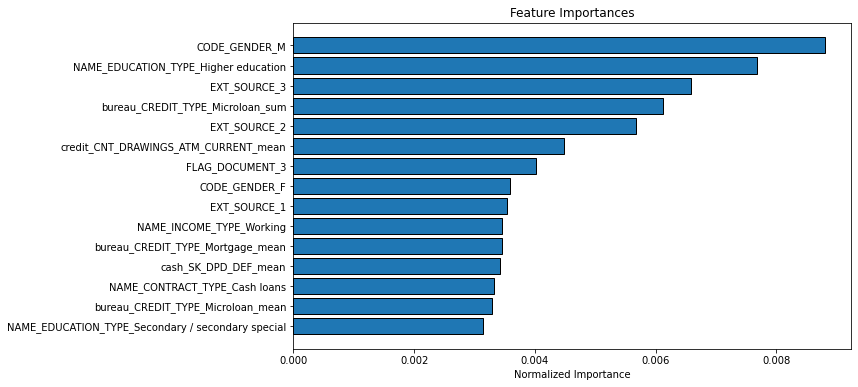

,index,feature,importance,importance_normalized
0,521,CODE_GENDER_M,0.008806,0.008806
1,541,NAME_EDUCATION_TYPE_Higher education,0.007687,0.007687
2,23,EXT_SOURCE_3,0.006586,0.006586
3,122,bureau_CREDIT_TYPE_Microloan_sum,0.006120,0.006120
4,22,EXT_SOURCE_2,0.005681,0.005681
...,...,...,...,...
654,231,cash_NAME_CONTRACT_STATUS_XNA_mean,0.000000,0.000000
655,232,cash_NAME_CONTRACT_STATUS_Canceled_mean,0.000000,0.000000
656,233,cash_NAME_CONTRACT_STATUS_Canceled_sum,0.000000,0.000000
657,104,bureau_CREDIT_CURRENCY_currency 4_mean,0.000000,0.000000


In [12]:
plot_feature_importances(feature_importances)

In [13]:
# let's use an LGBMClassifier for this
from lightgbm import LGBMClassifier 

def train_model(features, test_features, encoding='ohe', n_folds=5):
    """Train and test model using cross validation
    
    Args:
          model: to use different models to train the dataset
          train_features: train dataset with the TARGET
          test_features: test dataset to predict on
          encoding: encoding scheme to use on the dataset. Either ohe/le
          n_folds: number of folds to use for cross validation
          
    Returns: 
            
            
            """
    labels = features['TARGET']
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    features = features.drop(columns=['TARGET', 'SK_ID_CURR'])
    test_features = test_features.drop(columns=['SK_ID_CURR'])
    
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        features, test_features = features.align(test_features, join='inner', axis=1)
        cat_indices = 'auto'
        
    elif encoding == 'le':
        label_encoder = LabelEncoder()
        cat_indices = []
        
        for i,col in enumerate(features):
            if features[col].dtype == 'object':
                label_encoder.fit(features[col])
                features[col] = label_encoder.transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))
                cat_indices.append(i)
    else:
        raise ValueError('encoding must either be ohe or le')
     
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
     # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices, early_stopping_rounds=100, verbose=200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [14]:
submission, feature_importances, metrics = train_model(app_train, app_test)

Training Data Shape:  (307511, 659)
Testing Data Shape:  (48744, 659)


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	train's auc: 0.827352	train's binary_logloss: 0.518687	valid's auc: 0.781874	valid's binary_logloss: 0.53734
[400]	train's auc: 0.862498	train's binary_logloss: 0.479942	valid's auc: 0.781809	valid's binary_logloss: 0.513203


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	train's auc: 0.826857	train's binary_logloss: 0.519162	valid's auc: 0.78405	valid's binary_logloss: 0.538816
[400]	train's auc: 0.862527	train's binary_logloss: 0.480232	valid's auc: 0.784668	valid's binary_logloss: 0.514324


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	train's auc: 0.828144	train's binary_logloss: 0.517478	valid's auc: 0.77359	valid's binary_logloss: 0.538575
[400]	train's auc: 0.86342	train's binary_logloss: 0.478141	valid's auc: 0.774743	valid's binary_logloss: 0.513973


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	train's auc: 0.827077	train's binary_logloss: 0.519183	valid's auc: 0.780559	valid's binary_logloss: 0.536221


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	train's auc: 0.826205	train's binary_logloss: 0.519935	valid's auc: 0.783403	valid's binary_logloss: 0.536432
[400]	train's auc: 0.861745	train's binary_logloss: 0.481014	valid's auc: 0.784735	valid's binary_logloss: 0.51189


In [15]:
submission.head()

,SK_ID_CURR,TARGET
0,100001,0.272836
1,100005,0.599777
2,100013,0.141220
3,100028,0.302084
4,100038,0.735801


In [16]:
submission.to_csv('lightgbm_model.csv', index=False)

This had a score of 0.78098 on the Kaggle board

In [18]:
# for the feature importances
feature_importances.sort_values(by='importance', ascending=False)

,feature,importance
517,CREDIT_TERM,395.8
21,EXT_SOURCE_1,364.8
22,EXT_SOURCE_2,297.8
23,EXT_SOURCE_3,290.4
5,DAYS_BIRTH,232.8
...,...,...
327,prev_NAME_PAYMENT_TYPE_Cashless from the accou...,0.0
330,prev_NAME_CASH_LOAN_PURPOSE_Buying a home_mean,0.0
331,prev_NAME_CASH_LOAN_PURPOSE_Buying a home_sum,0.0
332,prev_NAME_SELLER_INDUSTRY_Tourism_mean,0.0


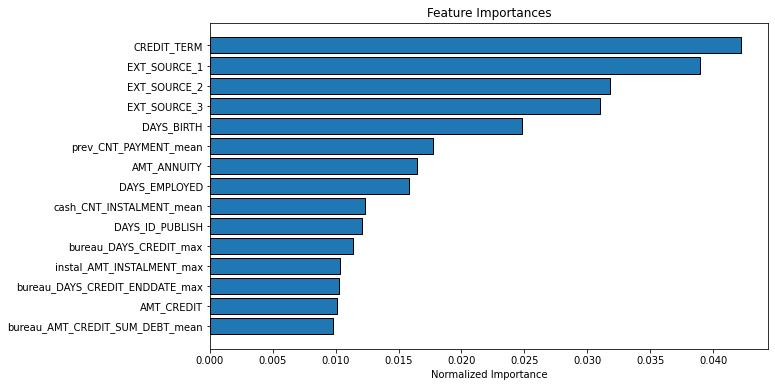

,index,feature,importance,importance_normalized
0,517,CREDIT_TERM,395.8,0.042232
1,21,EXT_SOURCE_1,364.8,0.038924
2,22,EXT_SOURCE_2,297.8,0.031776
3,23,EXT_SOURCE_3,290.4,0.030986
4,5,DAYS_BIRTH,232.8,0.024840
...,...,...,...,...
654,327,prev_NAME_PAYMENT_TYPE_Cashless from the accou...,0.0,0.000000
655,330,prev_NAME_CASH_LOAN_PURPOSE_Buying a home_mean,0.0,0.000000
656,331,prev_NAME_CASH_LOAN_PURPOSE_Buying a home_sum,0.0,0.000000
657,332,prev_NAME_SELLER_INDUSTRY_Tourism_mean,0.0,0.000000


In [19]:
plot_feature_importances(feature_importances)

Let's continue with the feature selection task